# Rock Paper Scissor

In [1]:
using Pkg, Revise
Pkg.activate(joinpath(@__DIR__, "../.."))
using EasyABM

  Activating project at `~/Documents/EasyABM`


WebIO._IJuliaInit()

## Step 1: Create Model

In this model, we work with patches only. We set `grid_size` to (50,50), set `space_type` to Periodic and define an additional model parameter `threshold` whose value is set to 3. 

In [2]:
model = create_2d_model(size = (50,50), space_type=Periodic, threshold = 3)

EasyABM SpaceModel2D{Static, Int64, NPeriodic}: In a Static model number of agents is fixed.


## Step 2: Initialise the model

In the second step we initialise the patches by defining `initialiser!` function and sending it as an argument to `init_model!`. In the `initialiser!` function we randomly assign `cl"red"` (for stone), `cl"green"` (for paper) and `cl"blue"` (for scissor) color to patches. Then we initialise the model using `init_model!` function, in which through the argument `props_to_record`, we tell EasyABM to record the `:color` property of patches during time evolution. Note that, in EasyABM animations are created with the recorded data, therefore if in the present model, the color of patches is not recorded there will be no animation to see. 

In [3]:
function initialiser!(model)
    for j in 1:model.size[2]
        for i in 1:model.size[1]
            num = rand()
            if num<0.33
                model.patches[i,j].color = cl"red" # stone => red, paper => green, scissor => blue
            elseif num>0.66
                model.patches[i,j].color = cl"green"
            else
                model.patches[i,j].color = cl"blue"
            end
        end
    end
end

init_model!(model, initialiser = initialiser!, props_to_record = Dict("patches" => Set([:color])))

## Step 3: Defining the step_rule! and running the model

In this step we define the `step_rule!` function and run the model for 400 steps. The rule of the game is very simple. The `cl"red"` color of a patch will change to `cl"green"` if number of neighboring patches with color `cl"green"` exceeds the threshold( which we set to be 3 in the beginning). Similarly, if a `cl"green"` patch finds larger than the threshold number of `cl"blue"` patches in its neighborhood, it will change to `cl"blue"`, and if a `cl"blue"` patch finds larger than threshold number of `cl"red"` patches in its neighborhood it will change to `cl"red"`. Each step of the model consists of 500 Monte-Carlo steps in which a patch is selected at random and the above mentioned rule applied to it. 

In [4]:
const who_wins_against = Dict(cl"red" => cl"green", cl"green" => cl"blue", cl"blue" => cl"red")

Dict{Col, Col} with 3 entries:
  RGBA{N0f8}(0.0,0.0,1.0,1.0… => RGBA{N0f8}(1.0,0.0,0.0,1.0)…
  RGBA{N0f8}(0.0,1.0,0.0,1.0… => RGBA{N0f8}(0.0,0.0,1.0,1.0)…
  RGBA{N0f8}(1.0,0.0,0.0,1.0… => RGBA{N0f8}(0.0,1.0,0.0,1.0)…

In [5]:
function step_rule!(model)
    for _ in 1:500
        i = rand(1:model.size[1])
        j = rand(1:model.size[2])
        nbr_patches = neighbor_patches((i,j), model, 1)
        col = model.patches[i,j].color
        winner_col = who_wins_against[col]
        count = 0 
        for patch in nbr_patches
            if model.patches[patch...].color == winner_col
                count+=1
            end
        end
        if count > model.parameters.threshold
            model.patches[i,j].color = winner_col
        end
    end
end

step_rule! (generic function with 1 method)

In [23]:
run_model!(model, steps = 400, step_rule = step_rule!)

## Step 4: Visualisation

In order to draw the model at a specific frame, say 4th, one can use

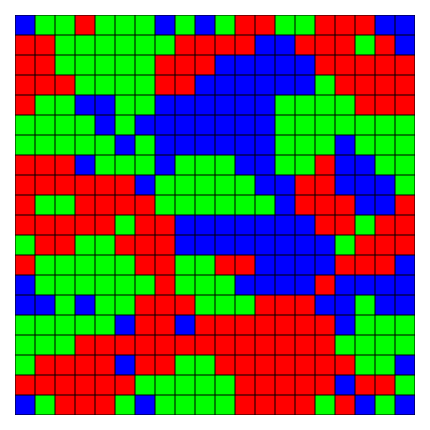

In [7]:
draw_frame(model, frame = 4, show_grid=true)

If one wants to see the animation of the model run, it can be done as 

In [18]:
animate_sim(model, show_grid=true) #since there are only patches and no agents, show_grid must be true for the animation

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 401, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(201), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007f4dc84b3210, Task (runnable) @0x00007f4dc84b3210), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (8, 0, 0)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n

After defining the `step_rule!` function we can also choose to create an interactive application (which currently works in Jupyter with WebIO installation) as 

In [6]:
create_interactive_app(model, initialiser= initialiser!,
    props_to_record = Dict("patches" => Set([:color])),
    step_rule= step_rule!,
    model_controls=[(:threshold, "slider", 1:8)], 
    frames=400, show_grid=true)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 400, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(1), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007f26b2548330, Task (runnable) @0x00007f26b2548330), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 139804209802640, 139804196321152)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 

## Step 5: Fetch Data 

It is easy to fetch any recorded data after running the model. For example, the numbers of different colored patches at all timesteps can be got as follows

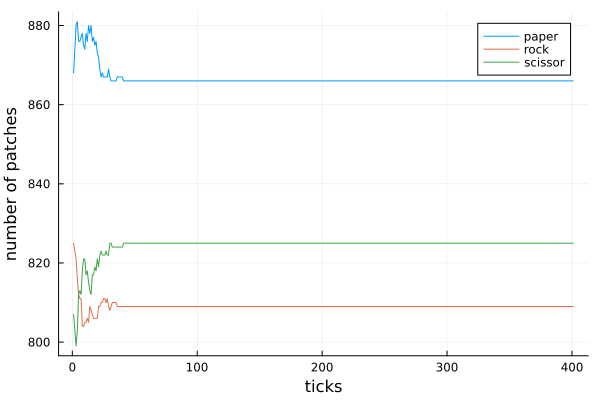

Row,paper,rock,scissor
,Int64,Int64,Int64
1,868,825,807
2,874,823,803
3,880,821,799
4,881,816,803
5,876,812,812
6,876,811,813
7,877,811,812
8,878,804,818
9,875,804,821


In [24]:
df = get_nums_patches(model, 
    patch-> patch.color ==cl"red", 
    patch-> patch.color ==cl"green", 
    patch-> patch.color ==cl"blue", labels=["rock","paper","scissor"], plot_result=true)